In [46]:
# 可视化
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

In [18]:
# list result files
results_dir = "./results"
result_list = []
for root, dirs, files in os.walk(results_dir):
        for file in files:
            if file.endswith(".csv"):
                result_list.append(file)
result_list


['local-redis-benchmark-client:100-query:20000.csv',
 'local-redis-benchmark-client:250-query:50000.csv',
 'local-redis-benchmark-client:300-query:60000.csv',
 'local-redis-benchmark-client:50-query:10000.csv',
 'local-redis-benchmark-client:200-query:40000.csv',
 'local-redis-benchmark-client:150-query:30000.csv',
 'local-redis-benchmark-client:350-query:70000.csv',
 'local-redis-benchmark-client:400-query:80000.csv']

In [19]:
# parse file name to get benchmark scale
def parse_scale(filename:str) -> str:
    filename = filename.removesuffix(".csv")
    tail = filename.split("-")[-2:]
    return (int(tail[0].split(":")[-1]), int(tail[1].split(":")[-1]))
parse_scale('./results/local-redis-benchmark-client:400-query:80000.csv')

(400, 80000)

In [40]:
# read result files
df_list = []
for filename in result_list:
    path = os.path.join(results_dir, filename)
    df_list.append((parse_scale(filename),
                    pd.read_csv(path).set_index("test")
                    ))
df_list

[((100, 20000),
                                             rps  avg_latency_ms  \
  test                                                             
  PING_INLINE                         1428571.38           0.888   
  PING_MBULK                          2000000.00           0.655   
  SET                                 1176470.50           1.079   
  GET                                 1428571.38           0.974   
  INCR                                1538461.50           0.870   
  LPUSH                               1176470.50           1.194   
  RPUSH                               1333333.38           1.036   
  LPOP                                1111111.12           1.290   
  RPOP                                1250000.00           1.095   
  SADD                                1111111.12           1.151   
  HSET                                1176470.50           1.183   
  SPOP                                1111111.12           1.144   
  ZADD                          

In [41]:
client_base = []
query_base = []
for t,_ in df_list:
    client_base.append(t[0])
    query_base.append(t[1])
client_base = min(client_base)
query_base = min(query_base)


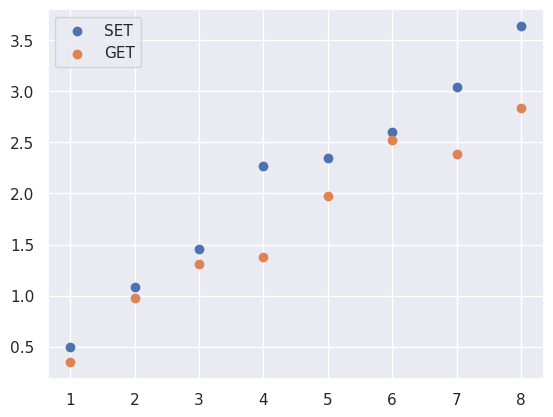

In [49]:
# 尝试画出set和get的latency变化图
x = []
y_set = []
y_get = []
for t, df in df_list:
    x.append(int(t[0]/client_base))
    y_set.append(df.loc["SET"]["avg_latency_ms"])
    y_get.append(df.loc["GET"]["avg_latency_ms"])
plt.figure()
plt.scatter(x,y_set)
plt.scatter(x,y_get)
plt.legend(["SET","GET"])
plt.show()